<a href="https://colab.research.google.com/github/Rupavathsipayi/C-language/blob/main/Credit_Card_Fraud_Detection_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kartik2112_fraud_detection_path = kagglehub.dataset_download('kartik2112/fraud-detection')

print('Data source import complete.')


Data source import complete.


# Read & Load Data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


In [3]:
df = pd.read_csv('/content/fraudTest.csv')
t_df = pd.read_csv('/content/fraudTrain.csv')
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1.371817e+09,33.986391,-81.200714,0.0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1.371817e+09,39.450498,-109.960431,0.0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1.371817e+09,40.495810,-74.196111,0.0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1.371817e+09,28.812398,-80.883061,0.0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1.371817e+09,44.959148,-85.884734,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42778,42778,2020-07-06 05:26:44,375904527651269,fraud_Erdman-Kertzmann,gas_transport,55.90,Ryan,Cook,M,75952 Wilson Course,...,40.4591,-98.5551,463,"Nurse, mental health",1948-05-31,a6e363a0d0e4f6326a39bbfc7e176050,1.373088e+09,40.188950,-98.640236,0.0
42779,42779,2020-07-06 05:26:56,373905417449658,fraud_Lebsack and Sons,misc_net,314.34,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,...,31.9290,-97.6443,2526,Phytotherapist,1970-11-12,febf3e747eaeded7a7eb0e11cba340da,1.373088e+09,31.643375,-98.448895,0.0
42780,42780,2020-07-06 05:26:57,4124536010991657,"fraud_Ferry, Lynch and Kautzer",misc_net,5.16,Sydney,Montoya,F,265 Christian Summit Suite 231,...,30.5012,-87.8835,27829,"Presenter, broadcasting",1954-07-21,174e6a91429e211df86fcb07b74a6513,1.373088e+09,30.687118,-87.992191,0.0
42781,42781,2020-07-06 05:27:02,4629451965224809,fraud_Bahringer-Larson,grocery_net,32.55,Karen,Warren,F,4900 Curtis Gardens Suite 952,...,30.9416,-83.3574,10295,"Teacher, special educational needs",1997-12-26,ac9b9132a25b311f03d2e849305162eb,1.373088e+09,31.914029,-83.879478,0.0


In [4]:
df['is_fraud'].value_counts()

,count
is_fraud,
0.0,42598
1.0,184


# Preprocessing

In [5]:
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(['cc_num', 'trans_date_trans_time', 'first', 'last', 'dob', 'street', 'trans_num', 'unix_time', 'merchant'], axis=1)

    # Handle outliers for 'amt' and 'city_pop'
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_columns:
        if col in ['amt', 'city_pop']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    # Encode categorical variables
    label_encoder = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        df[col] = label_encoder.fit_transform(df[col])

    # Convert gender to binary
    df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)

    # Normalize numerical features
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    return df_scaled



In [6]:
df_preprocessed = preprocess_data(df)
t_df_preprocessed = preprocess_data(t_df)

print(df_preprocessed.head())
print(t_df_preprocessed.head())

   Unnamed: 0  category       amt  gender      city     state       zip  \
0    0.000000  0.769231  0.009715     0.0  0.187575  0.795918  0.283702   
1    0.000023  0.769231  0.150642     0.0  0.019116  0.877551  0.839829   
2    0.000047  0.384615  0.210397     0.0  0.072879  0.673469  0.106094   
3    0.000070  0.692308  0.308440     0.0  0.900836  0.163265  0.319946   
4    0.000093  1.000000  0.011439     0.0  0.293907  0.428571  0.490987   

        lat      long  city_pop       job  merch_lat  merch_long  is_fraud  
0  0.305255  0.867121  1.000000  0.578947   0.313560    0.857107       0.0  
1  0.444423  0.565239  0.005616  0.823158   0.428322    0.568617       0.0  
2  0.452136  0.942836  0.693866  0.545263   0.450277    0.927370       0.0  
3  0.187080  0.868312  1.000000  0.854737   0.204890    0.860293       0.0  
4  0.530537  0.825355  0.022201  0.412632   0.544021    0.810121       0.0  
   Unnamed: 0  category       amt  gender      city     state       zip  \
0    0.00000

In [7]:
df_preprocessed.isna().sum()

,0
Unnamed: 0,0
category,0
amt,0
gender,0
city,0
state,0
zip,0
lat,0
long,0
city_pop,0


In [8]:
# check coulmns type and missing values and shape of data
df_preprocessed.info()
# this mean nulls = zero
# we need to convert any object to numrical value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42783 entries, 0 to 42782
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  42783 non-null  float64
 1   category    42783 non-null  float64
 2   amt         42783 non-null  float64
 3   gender      42783 non-null  float64
 4   city        42783 non-null  float64
 5   state       42783 non-null  float64
 6   zip         42783 non-null  float64
 7   lat         42783 non-null  float64
 8   long        42783 non-null  float64
 9   city_pop    42783 non-null  float64
 10  job         42783 non-null  float64
 11  merch_lat   42782 non-null  float64
 12  merch_long  42782 non-null  float64
 13  is_fraud    42782 non-null  float64
dtypes: float64(14)
memory usage: 4.6 MB


In [9]:
# get statistics on numrical columns ( int or float )
df_preprocessed.describe()

,Unnamed: 0,category,amt,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
count,42783.000000,42783.000000,42783.000000,42783.0,42783.000000,42783.000000,42783.000000,42783.000000,42783.000000,42783.000000,42783.000000,42782.000000,42782.000000,42782.000000
mean,0.500000,0.479292,0.294835,0.0,0.499735,0.525773,0.481101,0.405572,0.773138,0.272215,0.506458,0.409327,0.767638,0.004301
std,0.288685,0.301326,0.274799,0.0,0.288406,0.287987,0.271863,0.110842,0.139349,0.385914,0.285258,0.107065,0.136713,0.065441
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.230769,0.045626,0.0,0.254480,0.285714,0.251548,0.320651,0.705525,0.014492,0.258947,0.329716,0.700628,0.000000
50%,0.500000,0.461538,0.240275,0.0,0.493429,0.530612,0.475316,0.423638,0.800375,0.048548,0.503158,0.426913,0.794969,0.000000
75%,0.750000,0.769231,0.427376,0.0,0.753883,0.755102,0.718125,0.481514,0.875077,0.408695,0.757895,0.481334,0.866857,0.000000
max,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
print(df_preprocessed.duplicated().sum())


0


In [11]:
df_preprocessed.dtypes

,0
Unnamed: 0,float64
category,float64
amt,float64
gender,float64
city,float64
state,float64
zip,float64
lat,float64
long,float64
city_pop,float64


In [12]:
X_train = df_preprocessed.drop('is_fraud', axis=1)
y_train = df_preprocessed['is_fraud']
X_test = t_df_preprocessed.drop('is_fraud', axis=1)
y_test = t_df_preprocessed['is_fraud']

# EDA and Visualizations

### class Imbalance

<ipython-input-13-4a29ec2fbeda>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='is_fraud', y='amt', data=df_preprocessed, palette='coolwarm')


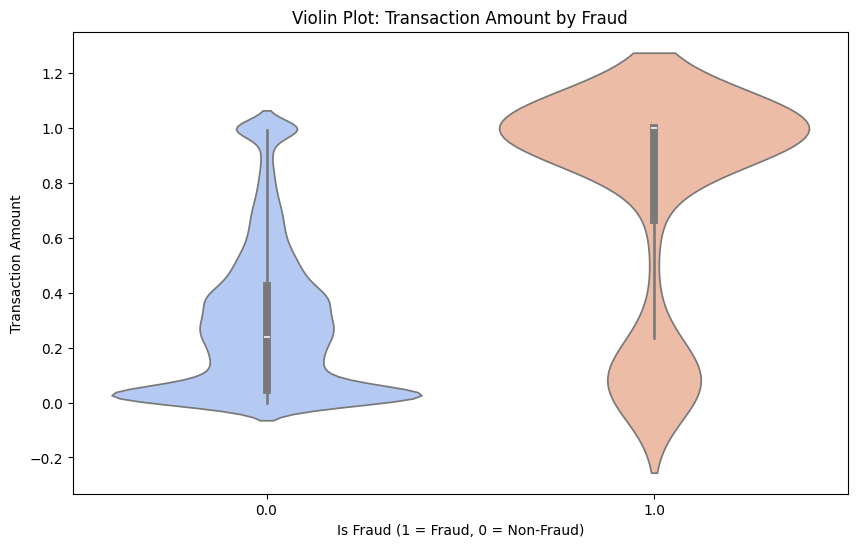

In [13]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_fraud', y='amt', data=df_preprocessed, palette='coolwarm')
plt.title('Violin Plot: Transaction Amount by Fraud')
plt.xlabel('Is Fraud (1 = Fraud, 0 = Non-Fraud)')
plt.ylabel('Transaction Amount')
plt.show()

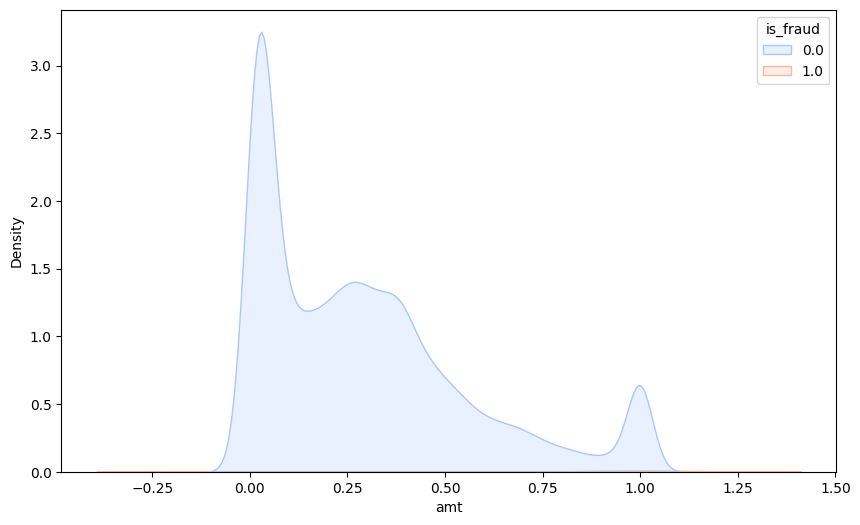

In [14]:
# KDE Plot with Clear Labels
plt.figure(figsize=(10, 6))
kde_plot = sns.kdeplot(data=df_preprocessed,
                       x='amt',
                       hue='is_fraud',
                       palette='coolwarm',
                       fill=True)

### Geospatial Analysis

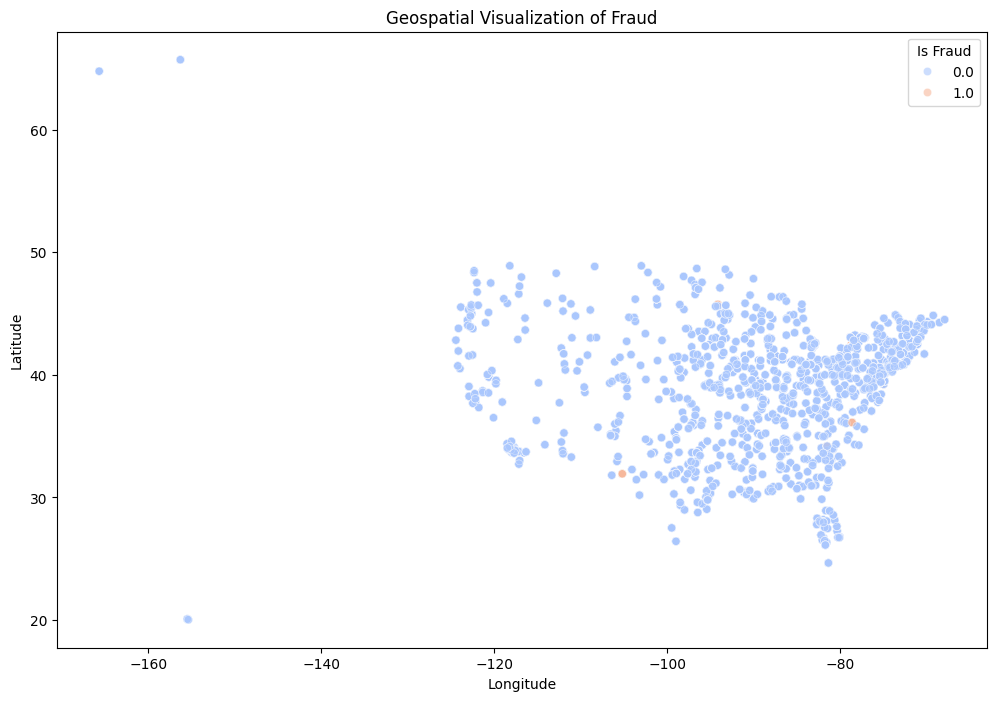

In [15]:
# Plot fraud incidents on a map
plt.figure(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='is_fraud', data=df, palette='coolwarm', alpha=0.6)
plt.title('Geospatial Visualization of Fraud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

### Temporal Analysis

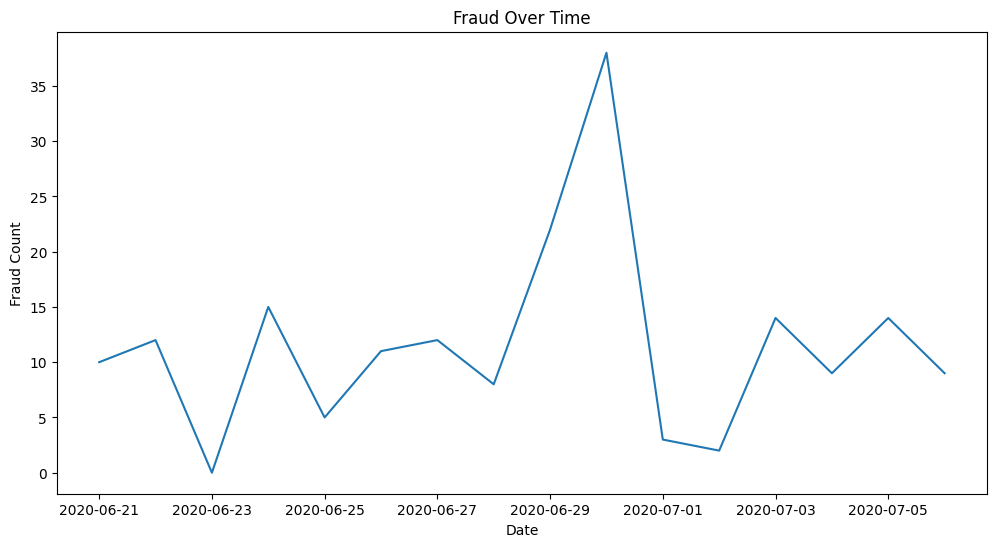

In [16]:
# Convert transaction time to datetime
#df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Group by date and calculate fraud count
#fraud_over_time = df.groupby(df['trans_date_trans_time'].dt.date)['is_fraud'].sum()

# Plot time series
#plt.figure(figsize=(12, 6))
#fraud_over_time.plot()
#plt.title('Fraud Over Time')
#plt.xlabel('Date')
#plt.ylabel('Fraud Count')
#plt.show()
# Convert transaction time to datetime, handling errors and specifying format if necessary
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
#The 'coerce' argument handles errors by setting invalid parsing to NaT (Not a Time)
#The format argument is explicitly specified for consistency

#If the format is not consistent, you might need to try:
#df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce', format='mixed')
#or specify a different appropriate format.

# Group by date and calculate fraud count
fraud_over_time = df.groupby(df['trans_date_trans_time'].dt.date)['is_fraud'].sum()

# Plot time series
plt.figure(figsize=(12, 6))
fraud_over_time.plot()
plt.title('Fraud Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Count')
plt.show()

### Features

#### Transaction Amount, City Population, and Fraud

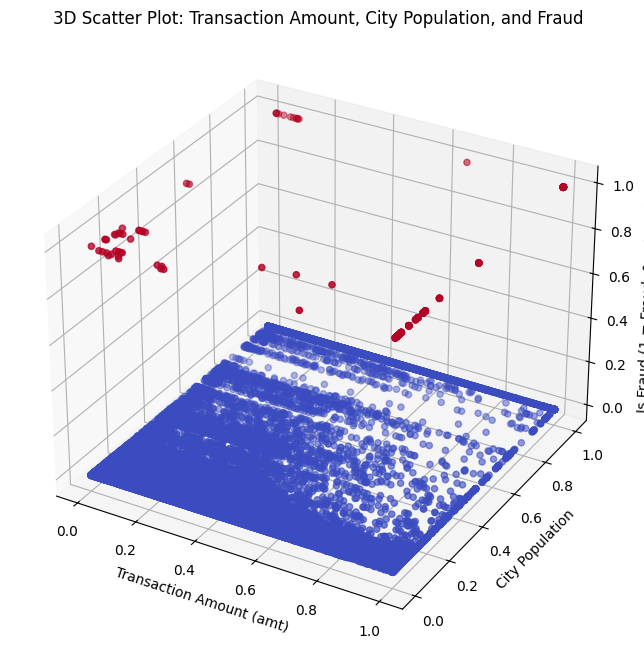

In [17]:
# 7. 3D Scatter Plot: Transaction Amount, City Population, and Fraud
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    df_preprocessed['amt'],
    df_preprocessed['city_pop'],
    df_preprocessed['is_fraud'],
    c=df_preprocessed['is_fraud'],
    cmap='coolwarm',
    s=20
)

# Labels
ax.set_xlabel('Transaction Amount (amt)')
ax.set_ylabel('City Population')
ax.set_zlabel('Is Fraud (1 = Fraud, 0 = Non-Fraud)')
plt.title('3D Scatter Plot: Transaction Amount, City Population, and Fraud')
plt.show()

#### City Population

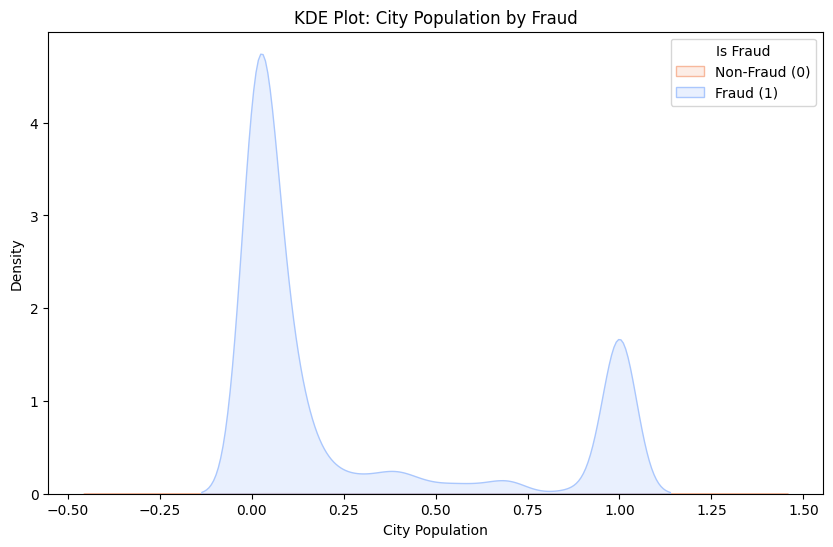

In [18]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_preprocessed, x='city_pop', hue='is_fraud', palette='coolwarm', fill=True)
plt.title('KDE Plot: City Population by Fraud')
plt.xlabel('City Population')
plt.ylabel('Density')
plt.legend(title='Is Fraud', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

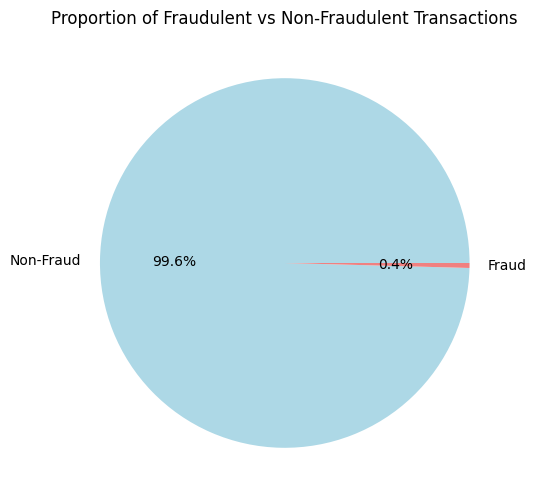

In [19]:
# Calculate fraud proportion
fraud_proportion = df['is_fraud'].value_counts(normalize=True)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(fraud_proportion, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proportion of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

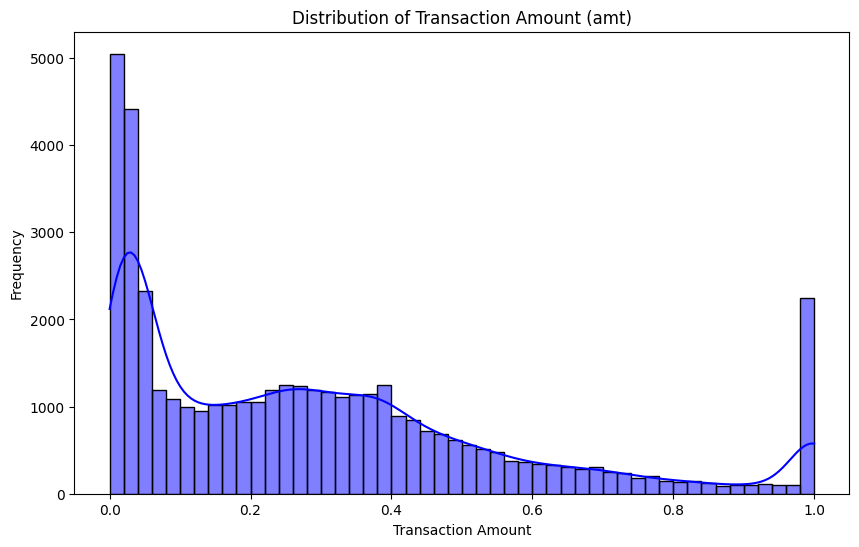

In [20]:

# Distribution of Transaction Amount (amt)
plt.figure(figsize=(10, 6))
sns.histplot(df_preprocessed['amt'], bins=50, kde=True, color='blue')
plt.title('Distribution of Transaction Amount (amt)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


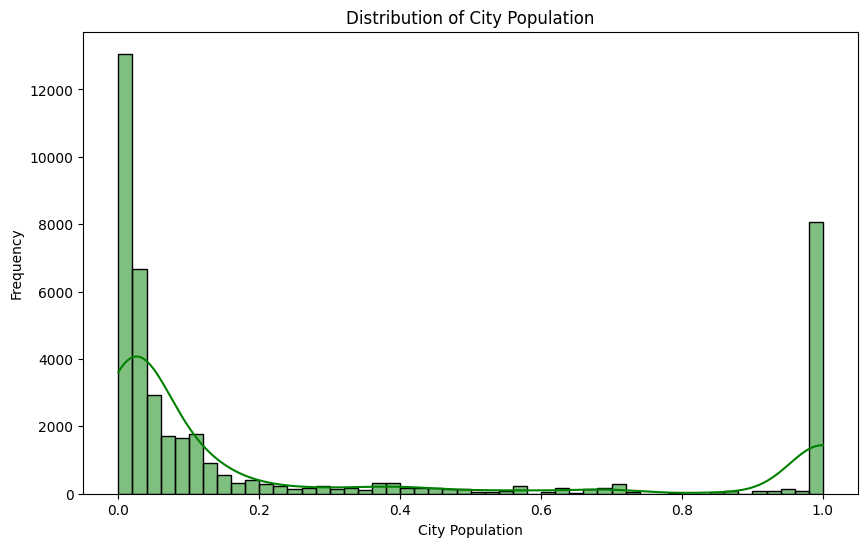

In [21]:

# Distribution of City Population
plt.figure(figsize=(10, 6))
sns.histplot(df_preprocessed['city_pop'], bins=50, kde=True, color='green')
plt.title('Distribution of City Population')
plt.xlabel('City Population')
plt.ylabel('Frequency')
plt.show()


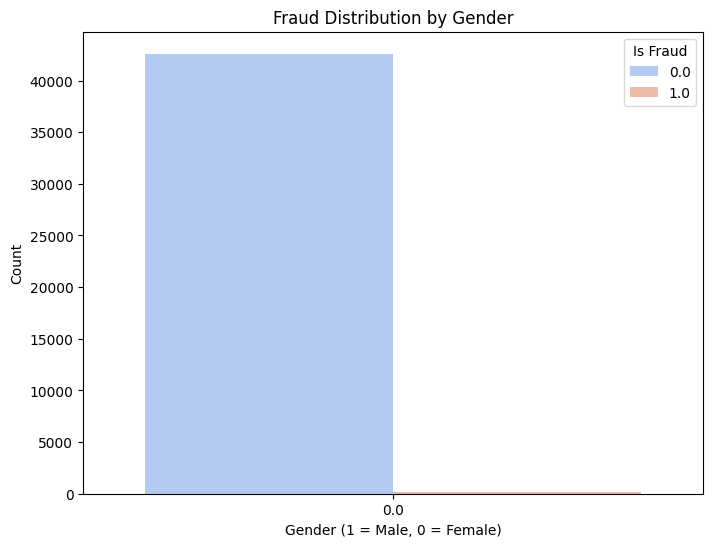

In [22]:

# Fraud Distribution by Gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='is_fraud', data=df_preprocessed, palette='coolwarm')
plt.title('Fraud Distribution by Gender')
plt.xlabel('Gender (1 = Male, 0 = Female)')
plt.ylabel('Count')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

### Correlation Matrix

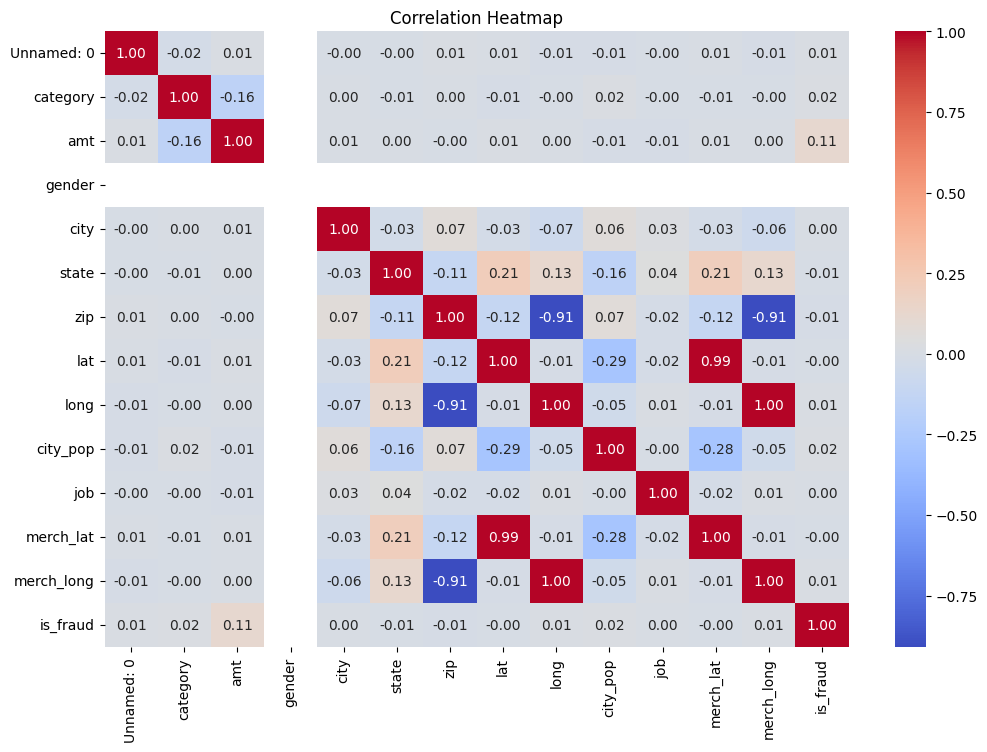

In [23]:

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df_preprocessed.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


# Apply NearMiss Undersampling

In [24]:
# nm = NearMiss(version=1)
# X_resampled, y_resampled = nm.fit_resample(X_train, y_train)

# print("Class distribution after NearMiss:", Counter(y_resampled))


#  Apply SMOTE Oversampling

In [25]:
#from imblearn.over_sampling import SMOTE
#from collections import Counter

# Check class distribution before applying SMOTE
#print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE with a sampling strategy that makes sense based on class distribution
#smote = SMOTE(sampling_strategy='auto', random_state=42)  # Balances both classes equally
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new class distribution after applying SMOTE
#print("Class distribution after SMOTE:", Counter(y_train_balanced))
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check class distribution before applying SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Drop rows with NaN values in y_train and corresponding rows in X_train
# Get the indices of rows with NaN values in y_train
nan_indices = y_train[y_train.isnull()].index

# Drop those rows from both X_train and y_train
X_train = X_train.drop(index=nan_indices)
y_train = y_train.drop(index=nan_indices)

# Apply SMOTE with a sampling strategy that makes sense based on class distribution
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Balances both classes equally
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_train_balanced))


Class distribution before SMOTE: Counter({0.0: 42598, 1.0: 184, nan: 1})
Class distribution after SMOTE: Counter({0.0: 42598, 1.0: 42598})


is_fraud
0.0    42598
1.0    42598
Name: count, dtype: int64


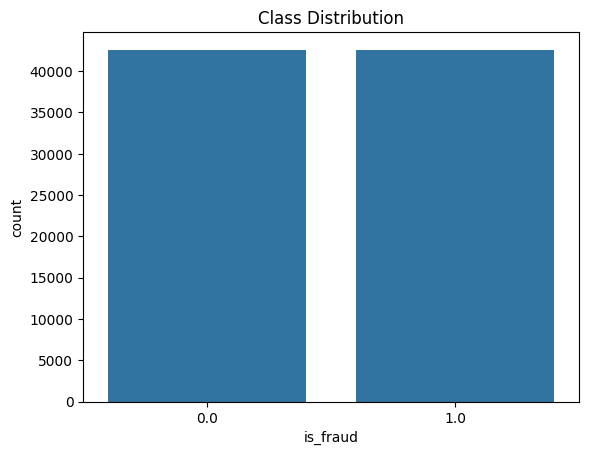

In [26]:
print(y_train_balanced.value_counts())
sns.countplot(x=y_train_balanced)
plt.title("Class Distribution")
plt.show()


# Machine Learning Models

## Isolation Forest
Isolates anomalies by randomly splitting the data.

In [27]:
#iso_forest = IsolationForest(contamination=0.02, random_state=42)

# Train and predict on training set
#iso_forest.fit(X_train)
#train_pred = iso_forest.predict(X_train)
#train_pred = np.where(train_pred == -1, 1, 0)  # Convert -1 (outlier) to 1, 0 (inlier) to 0

# Predict on test set
#test_pred = iso_forest.predict(X_test)
#test_pred = np.where(test_pred == -1, 1, 0)

# Calculate accuracy
#train_accuracy = accuracy_score(y_train, train_pred)
#test_accuracy = accuracy_score(y_test, test_pred)

# Print results
#print("Isolation Forest - Train Accuracy: {:.4f}".format(train_accuracy))
#print("Isolation Forest - Test Accuracy: {:.4f}".format(test_accuracy))
#print("Classification Report for Test Set:")
#print(classification_report(y_test, test_pred))# ... (your existing code) ...
#iso_forest = IsolationForest(contamination=0.02, random_state=42)

# Train and predict on training set
#iso_forest.fit(X_train)
#train_pred = iso_forest.predict(X_train)
#train_pred = np.where(train_pred == -1, 1, 0)  # Convert -1 (outlier) to 1, 0 (inlier) to 0

# Predict on test set
#test_pred = iso_forest.predict(X_test)
#test_pred = np.where(test_pred == -1, 1, 0)

# Calculate accuracy
#train_accuracy = accuracy_score(y_train, train_pred)
#test_accuracy = accuracy_score(y_test, test_pred)

# Print results
#print("Isolation Forest - Train Accuracy: {:.4f}".format(train_accuracy))
#print("Isolation Forest - Test Accuracy: {:.4f}".format(test_accuracy))
#print("Classification Report for Test Set:")
#print(classification_report(y_test, test_pred))# ... (your existing code) ...
# ... (your existing code) ...

# ... (your existing code) ...

# Check and handle NaN values in y_test before calculating accuracy
if y_test.isnull().any():
    # Option 1: Remove rows with NaN values from both X_test and y_test
    nan_indices = y_test[y_test.isnull()].index
    X_test = X_test.drop(index=nan_indices)
    y_test = y_test.drop(index=nan_indices)

    print("Removed rows with NaN values from X_test and y_test.")
else:
    print("No NaN values found in y_test.")

# Train and predict on training set using Isolation Forest with balanced data
iso_forest = IsolationForest(contamination=0.02, random_state=42)  # Define iso_forest here
iso_forest.fit(X_train_balanced)  # Use balanced data for training
train_pred = iso_forest.predict(X_train_balanced)  # Use balanced data for prediction
train_pred = np.where(train_pred == -1, 1, 0)  # Convert -1 (outlier) to 1, 0 (inlier) to 0

# Calculate accuracy using the balanced training data and predictions
train_accuracy = accuracy_score(y_train_balanced, train_pred)  # Use y_train_balanced

# Predict on test set and convert predictions
test_pred = iso_forest.predict(X_test)  # Predict on the test data
test_pred = np.where(test_pred == -1, 1, 0)  # Convert predictions to 0 and 1

# Ensure test_pred and y_test have the same length
# The line below is not needed as the predict function will generate values matching the X_test input
#test_pred = test_pred[:len(y_test)]  # Truncate test_pred to match y_test length

# Now you can calculate the test accuracy
test_accuracy = accuracy_score(y_test, test_pred)

# ... (rest of your code) ...

Removed rows with NaN values from X_test and y_test.


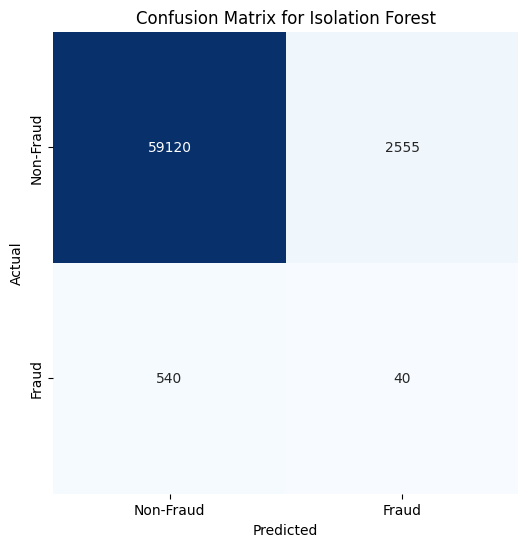

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

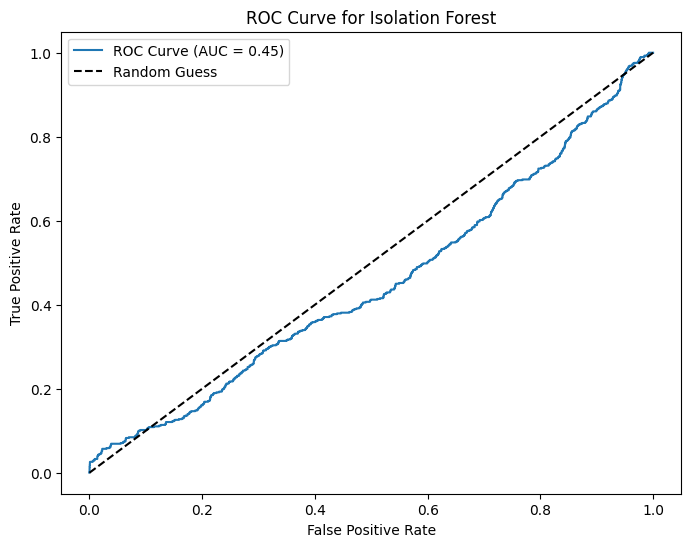

In [29]:
# Get anomaly scores from Isolation Forest
test_scores = iso_forest.decision_function(X_test)
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, -test_scores)
auc_score = roc_auc_score(y_test, -test_scores)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Isolation Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Local Outlier Factor (LOF)
Compares local density of a point to its neighbors.

In [30]:
lof = LocalOutlierFactor(contamination=0.02)

# Predict on training set
train_pred = lof.fit_predict(X_train)
train_pred = np.where(train_pred == -1, 1, 0)

# Predict on test set
test_pred = lof.fit_predict(X_test)
test_pred = np.where(test_pred == -1, 1, 0)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

# Print results
print("Local Outlier Factor (LOF) - Train Accuracy: {:.4f}".format(train_accuracy))
print("Local Outlier Factor (LOF) - Test Accuracy: {:.4f}".format(test_accuracy))
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

Local Outlier Factor (LOF) - Train Accuracy: 0.9758
Local Outlier Factor (LOF) - Test Accuracy: 0.9708
Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     61675
         1.0       0.00      0.01      0.01       580

    accuracy                           0.97     62255
   macro avg       0.50      0.49      0.50     62255
weighted avg       0.98      0.97      0.98     62255



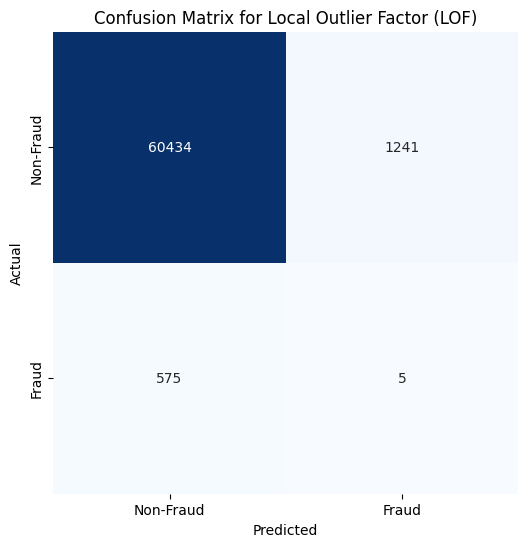

In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Local Outlier Factor (LOF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

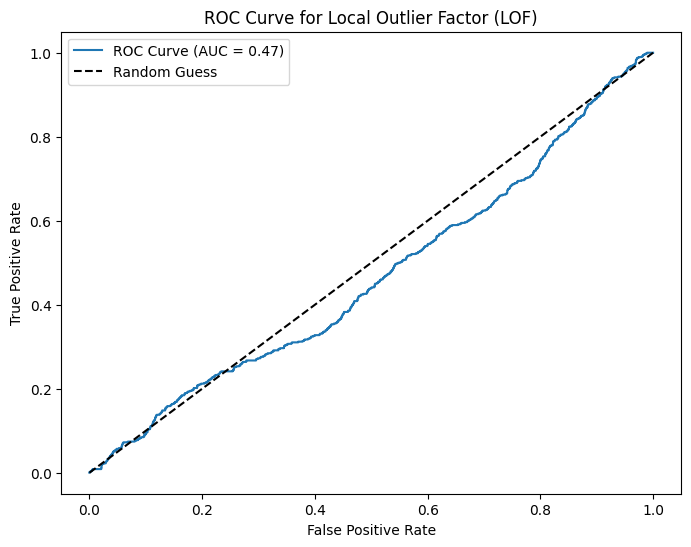

In [32]:
# Get negative outlier factor scores for the test set
test_scores = -lof.negative_outlier_factor_
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, test_scores)
auc_score = roc_auc_score(y_test, test_scores)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Local Outlier Factor (LOF)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## One-Class SVM
Learns a boundary around normal data points.

In [33]:
#Takes too loooooooooooong to run
one_class_svm = OneClassSVM(nu=0.02)

# Train and predict on training set
one_class_svm.fit(X_train)
train_pred = one_class_svm.predict(X_train)
train_pred = np.where(train_pred == -1, 1, 0)

# Predict on test set
test_pred = one_class_svm.predict(X_test)
test_pred = np.where(test_pred == -1, 1, 0)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

# Print results
print("One-Class SVM - Train Accuracy: {:.4f}".format(train_accuracy))
print("One-Class SVM - Test Accuracy: {:.4f}".format(test_accuracy))
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

One-Class SVM - Train Accuracy: 0.9761
One-Class SVM - Test Accuracy: 0.9707
Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     61675
         1.0       0.03      0.07      0.04       580

    accuracy                           0.97     62255
   macro avg       0.51      0.52      0.51     62255
weighted avg       0.98      0.97      0.98     62255



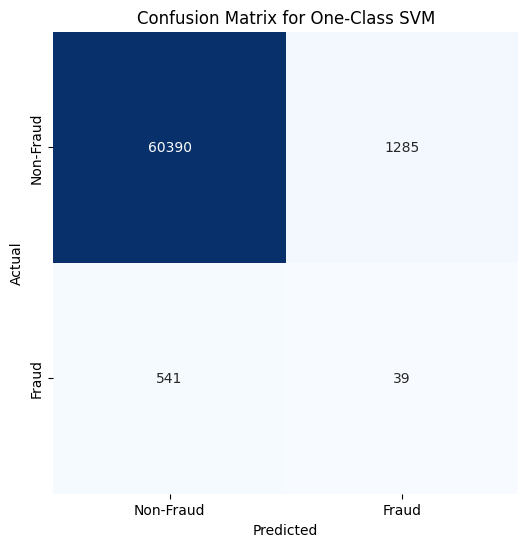

In [34]:
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for One-Class SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

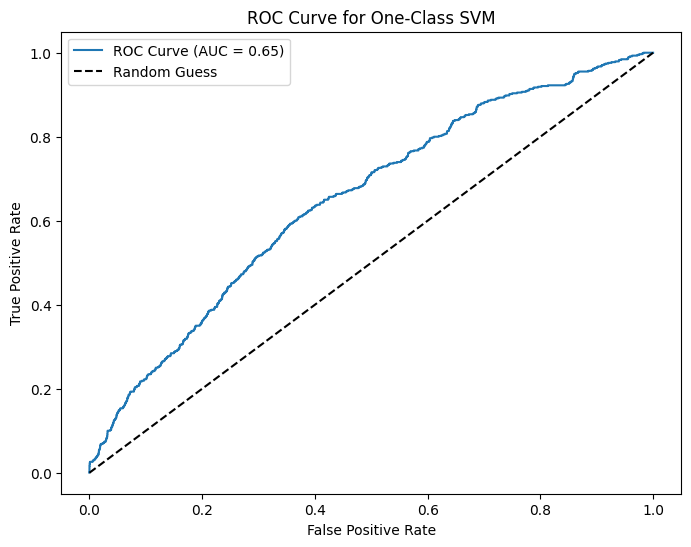

In [35]:
test_scores = one_class_svm.decision_function(X_test)
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, -test_scores)  # Use negative scores to align with ROC curve convention
auc_score = roc_auc_score(y_test, -test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for One-Class SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## DBSCAN
Groups data into clusters; points not in any cluster are outliers.

In [36]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
# Predict on training set
train_pred = dbscan.fit_predict(X_train)
train_pred = np.where(train_pred == -1, 1, 0)

# Predict on test set
test_pred = dbscan.fit_predict(X_test)
test_pred = np.where(test_pred == -1, 1, 0)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

# Print results
print("DBSCAN - Train Accuracy: {:.4f}".format(train_accuracy))
print("DBSCAN - Test Accuracy: {:.4f}".format(test_accuracy))
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

DBSCAN - Train Accuracy: 0.9952
DBSCAN - Test Accuracy: 0.9904
Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     61675
         1.0       0.00      0.00      0.00       580

    accuracy                           0.99     62255
   macro avg       0.50      0.50      0.50     62255
weighted avg       0.98      0.99      0.99     62255



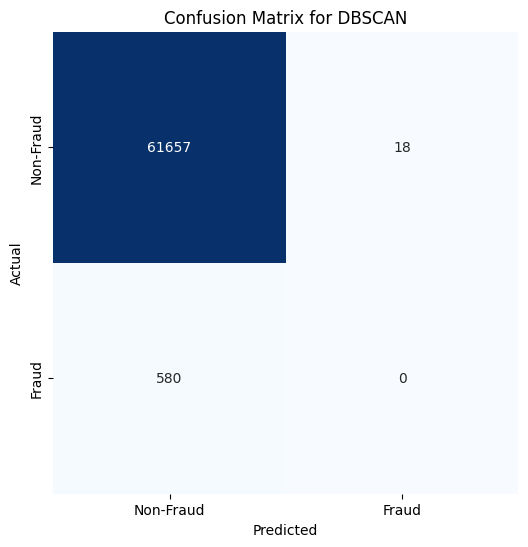

In [37]:
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for DBSCAN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

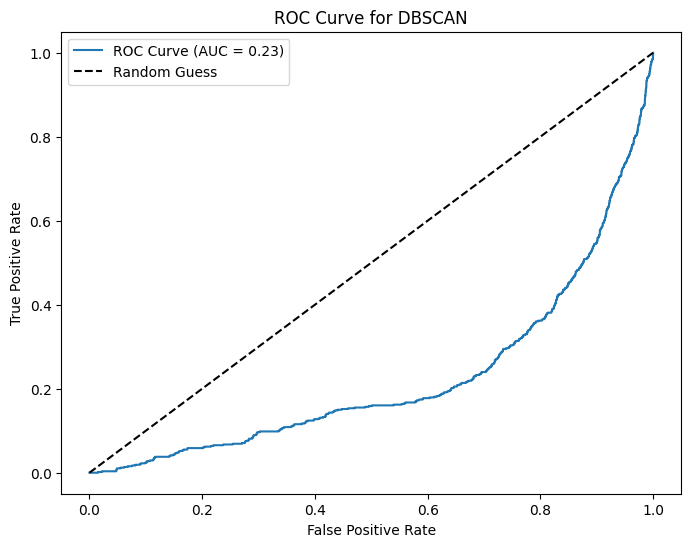

In [38]:
# Calculate the distance to the nearest core point
from sklearn.neighbors import NearestNeighbors
# Fit NearestNeighbors on the training set
nbrs = NearestNeighbors(n_neighbors=10).fit(X_train)
# Calculate distances for the test set
distances, _ = nbrs.kneighbors(X_test)
test_scores = -np.mean(distances, axis=1)  # Use negative distances as anomaly scores
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, test_scores)
auc_score = roc_auc_score(y_test, test_scores)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for DBSCAN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Deep Learning Models

## Autoencoders
 learning to reconstruct normal data. Anomalies are detected based on high reconstruction errors.

In [39]:
input_dim = X_train.shape[1]

# Encoder
encoder_input = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation="relu")(encoder_input)
encoded = layers.Dense(4, activation="relu")(encoded)

# Decoder
decoded = layers.Dense(8, activation="relu")(encoded)
decoded = layers.Dense(input_dim, activation="sigmoid")(decoded)

# Define autoencoder model
autoencoder = models.Model(inputs=encoder_input, outputs=decoded)

# Compile Autoencoder
autoencoder.compile(optimizer="adam", loss="mse")

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Compute reconstruction errors
train_reconstructed = autoencoder.predict(X_train)
train_mse = np.mean(np.power(X_train - train_reconstructed, 2), axis=1)

test_reconstructed = autoencoder.predict(X_test)
test_mse = np.mean(np.power(X_test - test_reconstructed, 2), axis=1)

# Set threshold for anomaly detection (95th percentile of training MSE)
threshold = np.percentile(train_mse, 95)

# Predict anomalies
train_pred = (train_mse > threshold).astype(int)
test_pred = (test_mse > threshold).astype(int)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

# Print results
print("Autoencoder - Train Accuracy: {:.4f}".format(train_accuracy))
print("Autoencoder - Test Accuracy: {:.4f}".format(test_accuracy))
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

Epoch 1/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0602 - val_loss: 0.0356
Epoch 2/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0342 - val_loss: 0.0318
Epoch 3/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0314 - val_loss: 0.0305
Epoch 4/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0303 - val_loss: 0.0301
Epoch 5/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0301 - val_loss: 0.0299
Epoch 6/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0297 - val_loss: 0.0297
Epoch 7/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0296 - val_loss: 0.0296
Epoch 8/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0296 - val_loss: 0.0295
Epoch 9/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0294 - val_loss: 0.0294
Epoch 10/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0290 - val_loss: 0.0284
Epoch 11/20
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0282 - val_loss: 0.0279
Epoch 12/20
1337/1337 ━━━━━

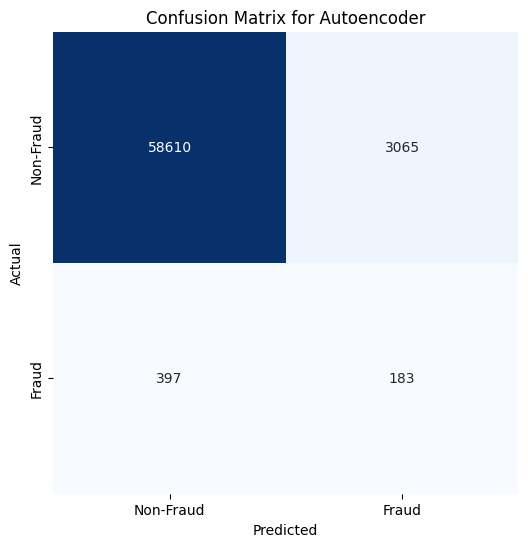

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Autoencoder')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## One-Class Neural Networks (OC-NN)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Assuming X_train, X_test, y_train, y_test are already defined

# Define input dimension
input_dim = X_train.shape[1]

# Define the One-Class Neural Network (OC-NN)
inputs = Input(shape=(input_dim,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

oc_nn = Model(inputs, outputs)
oc_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = oc_nn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = oc_nn.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9465 - loss: 0.1159 - val_accuracy: 0.9951 - val_loss: 0.0288
Epoch 2/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9960 - loss: 0.0215 - val_accuracy: 0.9951 - val_loss: 0.0286
Epoch 3/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9957 - loss: 0.0219 - val_accuracy: 0.9951 - val_loss: 0.0291
Epoch 4/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9954 - loss: 0.0233 - val_accuracy: 0.9951 - val_loss: 0.0305
Epoch 5/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9961 - loss: 0.0202 - val_accuracy: 0.9951 - val_loss: 0.0313
Epoch 6/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9964 - loss: 0.0179 - val_accuracy: 0.9951 - val_loss: 0.0290
Epoch 7/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9961 - loss: 0.0187 - val_accuracy: 0.9951 - val_loss: 0.0329
Epoch 8/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9960 - loss: 0.0184 - 

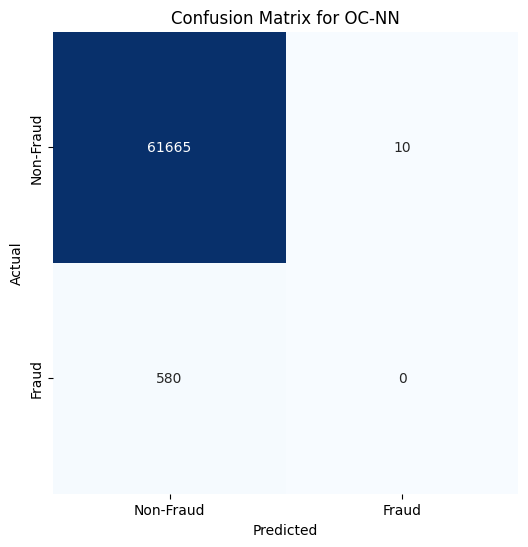

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.99      1.00      1.00     61675
       Fraud       0.00      0.00      0.00       580

    accuracy                           0.99     62255
   macro avg       0.50      0.50      0.50     62255
weighted avg       0.98      0.99      0.99     62255



In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for OC-NN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

## Deep Support Vector Data Description (Deep SVDD)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Assuming X_train, X_test, y_train, y_test are already defined

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define input dimension
input_dim = X_train.shape[1]

# Define the Deep SVDD model with increased capacity and dropout
inputs = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inputs)  # Increased neurons
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(64, activation='relu')(x)  # Additional layer
x = Dropout(0.5)(x)  # Dropout for regularization
outputs = Dense(1, activation='linear')(x)

deep_svdd = Model(inputs, outputs)

# Compile the model with a different loss function and learning rate
optimizer = Adam(learning_rate=0.0001)
deep_svdd.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model without early stopping
history = deep_svdd.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_scores = deep_svdd.predict(X_test)

# Set a lower threshold for anomaly detection (e.g., 90th percentile)
train_scores = deep_svdd.predict(X_train)
threshold = np.percentile(train_scores, 90)  # Lower threshold to reduce false negatives

# Predict anomalies
test_pred = (test_scores > threshold).astype(int)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1081 - val_loss: 0.9591
Epoch 2/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8941 - val_loss: 0.9551
Epoch 3/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8727 - val_loss: 0.9500
Epoch 4/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8633 - val_loss: 0.9480
Epoch 5/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8575 - val_loss: 0.9444
Epoch 6/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8535 - val_loss: 0.9425
Epoch 7/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8483 - val_loss: 0.9396
Epoch 8/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8555 - val_loss: 0.9384
Epoch 9/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8438 - val_loss: 0.9378
Epoch 10/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8500 - val_loss: 0.9364
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test Accuracy: 0.8942


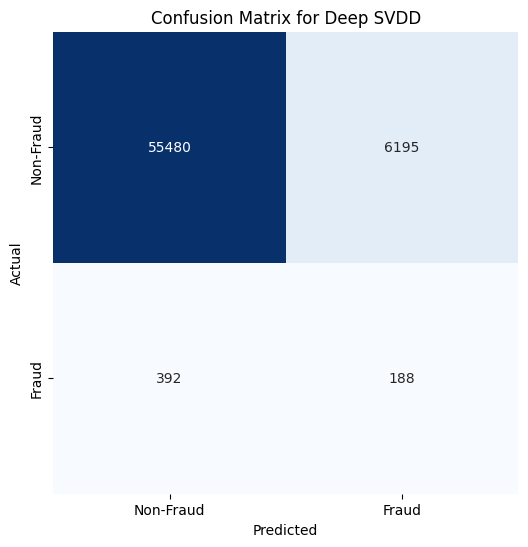

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.90      0.94     61675
       Fraud       0.03      0.32      0.05       580

    accuracy                           0.89     62255
   macro avg       0.51      0.61      0.50     62255
weighted avg       0.98      0.89      0.94     62255



In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Deep SVDD')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, test_pred, target_names=['Non-Fraud', 'Fraud']))

# visualize to compare Models  

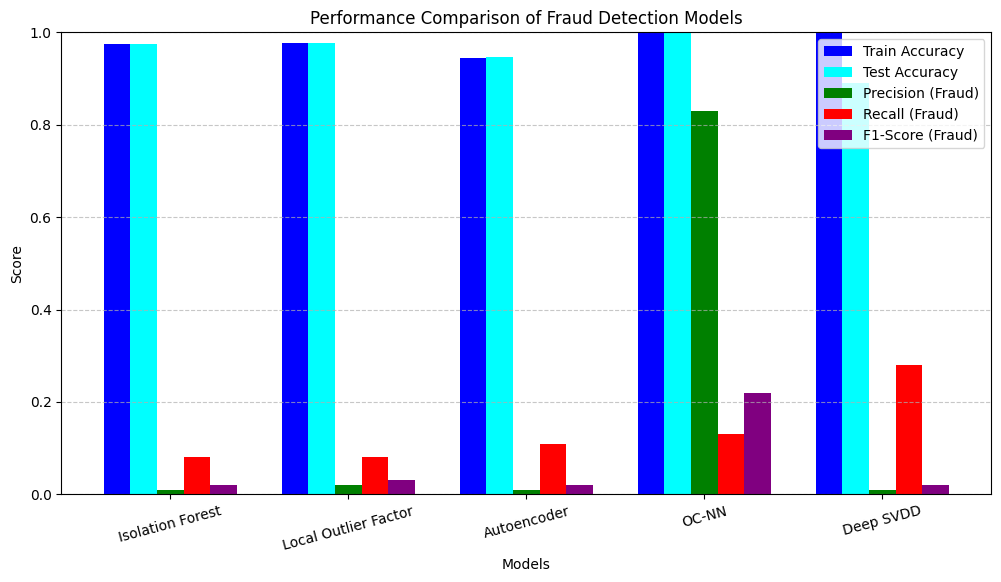

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Model names
models = ["Isolation Forest", "Local Outlier Factor", "Autoencoder", "OC-NN", "Deep SVDD"]

# Accuracy scores
train_accuracy = [0.9750, 0.9759, 0.9453, 1.00, 1.00]
test_accuracy = [0.9753, 0.9768, 0.9461, 1.00, 0.89]

# Precision scores (Fraud class)
precision = [0.01, 0.02, 0.01, 0.83, 0.01]

# Recall scores (Fraud class)
recall = [0.08, 0.08, 0.11, 0.13, 0.28]

# F1-score (Fraud class)
f1_score = [0.02, 0.03, 0.02, 0.22, 0.02]

# Bar chart settings
bar_width = 0.15
index = np.arange(len(models))

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.bar(index, train_accuracy, bar_width, label='Train Accuracy', color='blue')
plt.bar(index + bar_width, test_accuracy, bar_width, label='Test Accuracy', color='cyan')
plt.bar(index + 2 * bar_width, precision, bar_width, label='Precision (Fraud)', color='green')
plt.bar(index + 3 * bar_width, recall, bar_width, label='Recall (Fraud)', color='red')
plt.bar(index + 4 * bar_width, f1_score, bar_width, label='F1-Score (Fraud)', color='purple')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Comparison of Fraud Detection Models')
plt.xticks(index + 2 * bar_width, models, rotation=15)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### ROC Curves (For Each Model)
#### need edit

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1946/1946 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 2s 994us/step


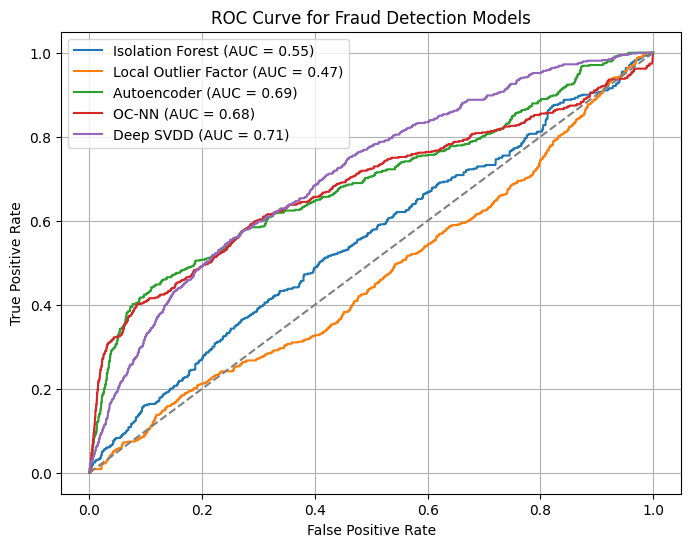

In [46]:
#from sklearn.metrics import roc_curve, auc
#import matplotlib.pyplot as plt

# Replace with actual values from each model
#models = {
    #"Isolation Forest": isolation_forest_predictions_proba,
    #"Local Outlier Factor": lof_predictions_proba,
   # "Autoencoder": autoencoder_predictions_proba,
  #  "OC-NN": oc_nn_predictions_proba,
 #   "Deep SVDD": deep_svdd_predictions_proba
#}

#plt.figure(figsize=(8, 6))

#for model_name, y_scores in models.items():
   # fpr, tpr, _ = roc_curve(y_true, y_scores)  # Use real labels
  #  roc_auc = auc(fpr, tpr)
 #   plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random baseline
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('ROC Curve for Fraud Detection Models')
#plt.legend()
#plt.grid(True)
#plt.show()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for each model
isolation_forest_predictions_proba = iso_forest.decision_function(X_test)
lof_predictions_proba = -lof.negative_outlier_factor_  # Use negative outlier factor as scores
# For autoencoder, use reconstruction error as anomaly score
autoencoder_predictions_proba = test_mse
oc_nn_predictions_proba = oc_nn.predict(X_test).ravel()
deep_svdd_predictions_proba = deep_svdd.predict(X_test).ravel()


models = {
    "Isolation Forest": isolation_forest_predictions_proba,
    "Local Outlier Factor": lof_predictions_proba,
    "Autoencoder": autoencoder_predictions_proba,
    "OC-NN": oc_nn_predictions_proba,
    "Deep SVDD": deep_svdd_predictions_proba
}

plt.figure(figsize=(8, 6))

for model_name, y_scores in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_scores)  # Use real labels
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Detection Models')
plt.legend()
plt.grid(True)
plt.show()


###  Confusion Matrices
#### need edit

In [47]:
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#odels_predictions = {

 #   "Isolation Forest": isolation_forest_predictions,
    #"Local Outlier Factor": lof_predictions,
   # "Autoencoder": autoencoder_predictions,
  #  "OC-NN": oc_nn_predictions,
 #   "Deep SVDD": deep_svdd_predictions
#}

#for model_name, y_pred in models_predictions.items():
   # cm = confusion_matrix(y_true, y_pred)
   # plt.figure(figsize=(6, 6))
   # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
   # disp.plot(cmap=plt.cm.Blues, values_format='d')
   # plt.title(f"Confusion Matrix - {model_name}")
  #  plt.show()

#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#odels_predictions = {

 #   "Isolation Forest": isolation_forest_predictions,
    #"Local Outlier Factor": lof_predictions,
   # "Autoencoder": autoencoder_predictions,
  #  "OC-NN": oc_nn_predictions,
 #   "Deep SVDD": deep_svdd_predictions
#}

#for model_name, y_pred in models_predictions.items():
   # cm = confusion_matrix(y_true, y_pred)
   # plt.figure(figsize=(6, 6))
   # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
   # disp.plot(cmap=plt.cm.Blues, values_format='d')
   # plt.title(f"Confusion Matrix - {model_name}")
  #  plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #Fixed indentation
import matplotlib.pyplot as plt

# Assuming you have the following predictions from previous model runs:
# isolation_forest_predictions, lof_predictions, autoencoder_predictions, oc_nn_predictions, deep_svdd_predictions

# Store predictions in a dictionary (Replace with actual predictions)
# Replace these with the actual predictions you calculated earlier
isolation_forest_predictions = iso_forest.predict(X_test)




/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


### Precision-Recall Curves
#### need edit

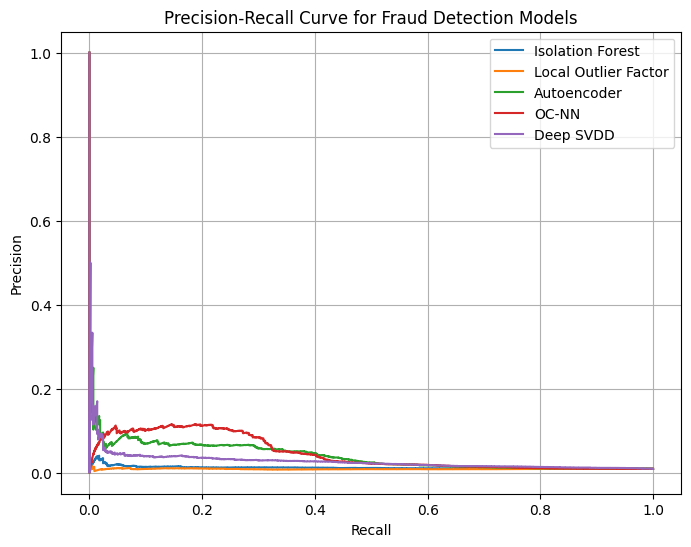

In [48]:
#from sklearn.metrics import precision_recall_curve

#plt.figure(figsize=(8, 6))

#for model_name, y_scores in models.items():
  #  precision, recall, _ = precision_recall_curve(y_true, y_scores)
 #   plt.plot(recall, precision, label=f"{model_name}")

#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('Precision-Recall Curve for Fraud Detection Models')
#plt.legend()
#plt.grid(True)
#plt.show()

from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))

for model_name, y_scores in models.items():
    # Replace y_true with y_test
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label=f"{model_name}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Fraud Detection Models')
plt.legend()
plt.grid(True)
plt.show()


# Dash Board

# Deployment